# Imports

In [24]:
from bs4 import BeautifulSoup
import requests
import re
import math
from datetime import datetime
import statistics
import scipy.stats as st
import random
import string
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import nltk
import scipy
nltk.download(["stopwords","punkt","names"])
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.patches as mpatches
from dateutil.relativedelta import relativedelta
import collections

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\Matth\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Matth\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Getting Amazon Review Data
## Generate cookies and headers for request

In [25]:
#Create the cookies and headers
cookie = {'session-id':'261-0624820-8189244',
        'ubid-acbuk':'257-5015255-6933932',
        'x-acbuk':"SHANeonOJaheMLxqVZ4msU4f4R@EmL3x",
        'at-acbuk':'Atza|IwEBIEnpF7WXlwtQsRyGZ7j2bTSRbzTBwDlAnOTyxuvo7Hvrhrn2dyp63ewuYjG4ia_InUZLsBocBwWU_fMQcC175R50rYypI0cd1zwygQibh3YcTNoC4w4rzORUj9CjWEky33VlVWjR03SMBLThsL1ThlCNlAbG2SSWBqYbpuYenZPGnGzsyRyykCwK-lWg_WvRnh8-ZbWAbCMCZnj4tQLVOdZD',
        'sess-at-acbuk':'"aCh5jaU0vQL4yngxb40ZUs3evR9B3Thcl34Fyde8oG8="',
        'sst-acbuk':'Sst1|PQFNcV_AOW-PykmKjih9sdAzCYa21f7Wv9FmpIdzxnMwOp3RMKf9c5iGeatKfYULnwIwkDfn_otu-l7g3xLyxdFLuJWBpuIo23QnEpM21f00qFJD1SB3ocTbbSgowpR3HTSLghqfkiGttlxXKUjjI3jgntN-q2sJuWdSkHYdQTYLL_4f2UAf6oENeuPJ9eXQfhi1TTmSBJx4GEvELHlMhuNCz7hGEB9k_JU8fP1qs6bAQnQIQ5v8m7UTGFawlDa7JwoSbr-aojXr8KbJA8K981Kxpk8mSy3tsDg77AiBzOsMY6M',
        'i18n-prefs':'GBP',
        'lc-acbuk':'en_GB',
        'av-timezone':'Europe/London',
        'session-token':'"+VfkDfO9fgKFPdKHAQnlKJz/jM7u+awmBduH5/PFl5ztXolz282+s/gJig/ma6wa199MlP38l+UB34qpiitev5XFOb5Tn7dRH5cnTCHuVrWu5NwEOQY9Z9PjAgXHSrTMNYRsNhf/5ehxk6RvDP/k62m3wvdxLv3FMQUkEy2kkqxkUhpJHuloo7YsSgiApoNh2M3qQykGoL1pnMX29K252A=="',
        'session-id-time':'2082758401l'
        }

header = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36',
    }

## Find URLs of all review pages
The total number of reviews is read from the page contents. Knowing there are 10 reviews per page, we calculate how many review pages exist. We can then generate the URLs of these pages.

In [26]:
#Find all URLs of pages
urls = []
starting_url = "https://www.amazon.co.uk/Nurofen-Joint-Relief-Strength-Percent/product-reviews/B01MTGCG88/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=1"
page = requests.get(starting_url,headers = header)
print(page)
soup = BeautifulSoup(page.content)
num_reviews = soup.findAll("div",{'data-hook':'cr-filter-info-review-rating-count'})
num_pages = 0
for result in num_reviews:
    result_string = str(result)
    result_string_clean = re.sub('<[^>]+>', '', result_string)
    result_stripped = result_string_clean.strip()
    result_substring = result_stripped.split(", ")[1].split(" ")[0].replace(',','')
    num_pages = math.ceil(int(result_substring)/10)

for i in range(num_pages):
    url = "https://www.amazon.co.uk/Nurofen-Joint-Relief-Strength-Percent/product-reviews/B01MTGCG88/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=" + str(i)
    urls.append(url)

<Response [200]>


## Getting the Reviews
This function gets the review text using the data hook for the body of the text and the date of the review

In [27]:
def getReviews(url):
    page = requests.get(str(url),cookies=cookie,headers = header)
    soup=BeautifulSoup(page.content)
    reviews = soup.findAll("span", {'data-hook':"review-body"})
    dates = soup.findAll("span", {'data-hook':"review-date"})
    return reviews,dates

Reviews are then retrieved from each of the previously generated URLs. The review data is cleaned, removing filler characters and formatting the review date to the datetime format.

In [28]:
review_list = []
for url in urls:
    reviews,dates = getReviews(url)
    for review,date in zip(reviews,dates):
        review_string = str(review)
        date_string = str(date).split("on ",1)[1][:-7]
        review_string_clean = re.sub('<[^>]+>', '', review_string)
        date_string_clean = re.sub('<[^>]+>', '', date_string)
        review_stripped = review_string_clean.strip()
        date_stripped = date_string_clean.strip()
        date_formatted = datetime.strptime(date_stripped, "%d %B %Y")
        review_list.append((review_stripped,date_formatted))

## Review Data Cleaning
Reviews are tokenized (broken down into their constitutive words), including removal of stopwords and standardization to lower case.

In [29]:
#Tokenizing responses
tokenized_reviews = []
stopwords = nltk.corpus.stopwords.words("english")

for review,date in tqdm(review_list):
    review = review.replace("n't","not")
    tokenized_review  = [word.lower() for word in word_tokenize(review) if word.lower() not in stopwords and word.lower() not in string.punctuation and word.lower() != "’"]
    if len(tokenized_review) != 0:
        tokenized_reviews.append((tokenized_review,date))

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4558.04it/s]


# Frequency Analysis
This code generates a frequency distribution of words used in the reviews. 
## Monograms
The most commonly used 25 words are then retrieved.

In [30]:
#Overall frequency analysis
tokenized_words = []

for review,date in tokenized_reviews:
    for word in review:
        tokenized_words.append(word)
        
fd = nltk.FreqDist(tokenized_words)
single_words = []
single_counts = []
for word,count in fd.most_common(25):
    single_words.append(word)
    single_counts.append(count)

## Bigrams
Words that commonly appear in pairs. Top 5 pairs are retrieved.

In [31]:
#Bigrams

bi_finder = nltk.collocations.BigramCollocationFinder.from_words(tokenized_words)

double_words = []
double_counts = []

for word,count in bi_finder.ngram_fd.most_common(5):
    double_words.append(word[0] + ", " + word[1])
    double_counts.append(count)

## Trigrams
Words that commonly appear in triplets. Top 5 triplets are retrieved.

In [32]:
#Trigrams

tri_finder = nltk.collocations.TrigramCollocationFinder.from_words(tokenized_words)

triple_words = []
triple_counts = []

for word,count in tri_finder.ngram_fd.most_common(5):
    triple_words.append(word[0] + ", " + word[1] + ", " + word[2])
    triple_counts.append(count)

## Visualization
Generates bar graphs for monograms, bigrams, and trigrams showing the most frequently used words and how frequently they were used.

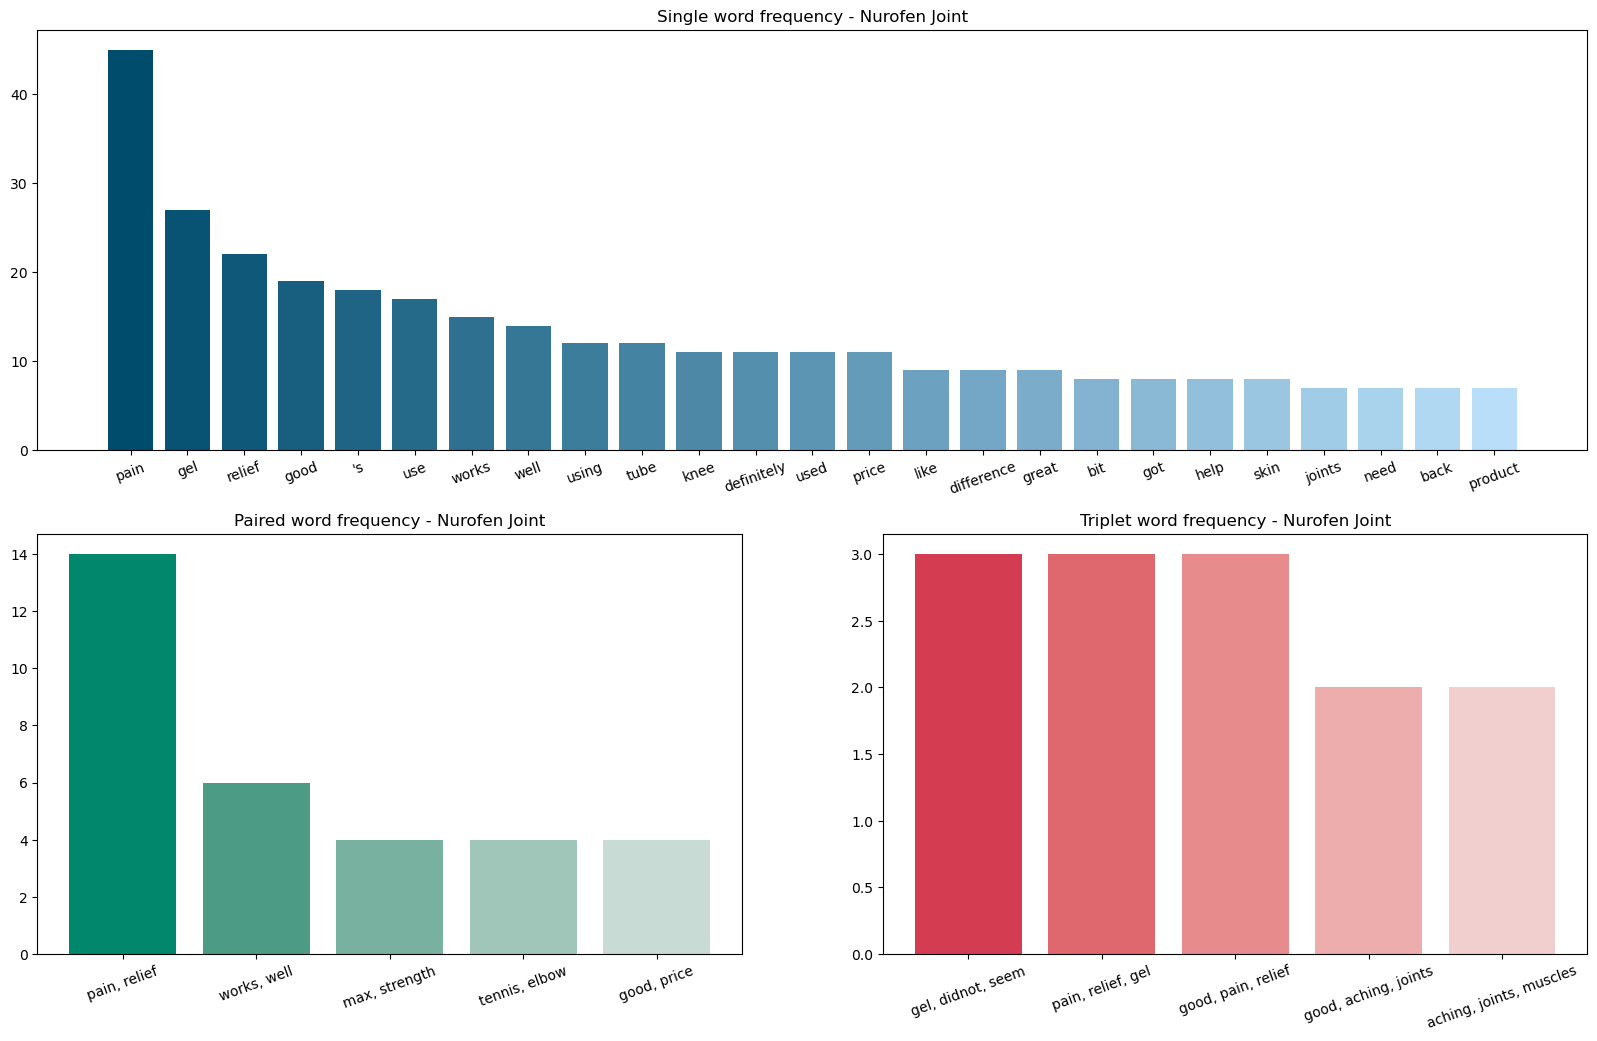

In [33]:
#Frequency graphs

colors1 = []
colors2 = ['#00876c','#4c9c85','#78b19f','#a0c6b9','#c8dbd5']
colors3 = ['#d43d51','#df676e','#e88b8d','#eeadad','#f1cfce']

for i in range(25):
    dark = (0, 76, 109)
    dark_r = dark[0]
    dark_g = dark[1]
    dark_b = dark[2]
    light = (192, 228, 255)
    light_r = light[0]
    light_g = light[1]
    light_b = light[2]
    
    diff_r = light_r - dark_r
    diff_g = light_g - dark_g
    diff_b = light_b - dark_b
    
    modifier = i/25
    new_color = ((dark_r + (diff_r*modifier))/255,(dark_g + (diff_g*modifier))/255,(dark_b + (diff_b*modifier))/255)
    colors1.append(new_color)

fig1 = plt.figure(figsize=(20,12))
fig1.add_subplot(2,1,1)
plt.bar(range(len(single_counts)),single_counts,tick_label=single_words,color = colors1)
plt.xticks(rotation=20)
plt.title("Single word frequency - Nurofen Joint")
fig1.add_subplot(2,2,3)
plt.bar(range(len(double_counts)),double_counts,tick_label=double_words,color = colors2)
plt.xticks(rotation=20)
plt.title("Paired word frequency - Nurofen Joint")
fig1.add_subplot(2,2,4)
plt.bar(range(len(triple_counts)),triple_counts,tick_label=triple_words,color = colors3)
plt.xticks(rotation=20)
plt.title("Triplet word frequency - Nurofen Joint")
plt.show()
fig1.savefig("Nurofen-Joint/nurofen_joint_word_frequencies")

# Sentiment Analysis
Sentiments are generated by the Sentiment Intensity Analyzer, then grouped into categories of their relative positivity/negativity.

In [34]:
#Sentiment analysis
sia = SentimentIntensityAnalyzer()

sentiments = []
grouped_sentiments = {
    "strong negative":0,
    "negative":0,
    "slight negative":0,
    "neutral":0,
    "slight positive":0,
    "positive":0,
    "strong positive":0
}

for review,date in tokenized_reviews:
    sentiments.append(sia.polarity_scores(" ".join(review))["compound"])
    
for sentiment in sentiments:
    if sentiment < -0.65:
        grouped_sentiments["strong negative"] += 1
    elif sentiment < -0.35:
        grouped_sentiments["negative"] += 1
    elif sentiment < -0.1:
        grouped_sentiments["slight negative"] += 1
    elif sentiment < 0.1:
        grouped_sentiments["neutral"] += 1
    elif sentiment < 0.35:
        grouped_sentiments["slight positive"] += 1
    elif sentiment < 0.65:
        grouped_sentiments["positive"] += 1
    else:
        grouped_sentiments["strong positive"] += 1
        
sentiment_labels = []
category_definitions = ["-1 to -0.66","-0.65 to -0.36","-0.35 to -0.11","-0.1 to 0.09","0.1 to 0.34","0.35 to 0.64","0.65 to 1"]
sentiment_counts = []
        
for category,count in grouped_sentiments.items():
        sentiment_labels.append(category)
        sentiment_counts.append(count)

## Sentiment analysis over time

[ 0  1  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27]
[ 0.22975     0.23263333 -0.0454      0.24546667  0.1858      0.4404
  0.3182      0.19960909 -0.0351      0.         -0.05435    -0.11878333
 -0.22873333  0.05766667  0.3614      0.2844      0.1147      0.4323
  0.4889      0.33693333  0.227375    0.5994      0.2285625   0.01107143
  0.5644      0.        ]


C:\Users\Matth\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\Matth\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\Users\Matth\miniconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Matth\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Matth\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2121: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


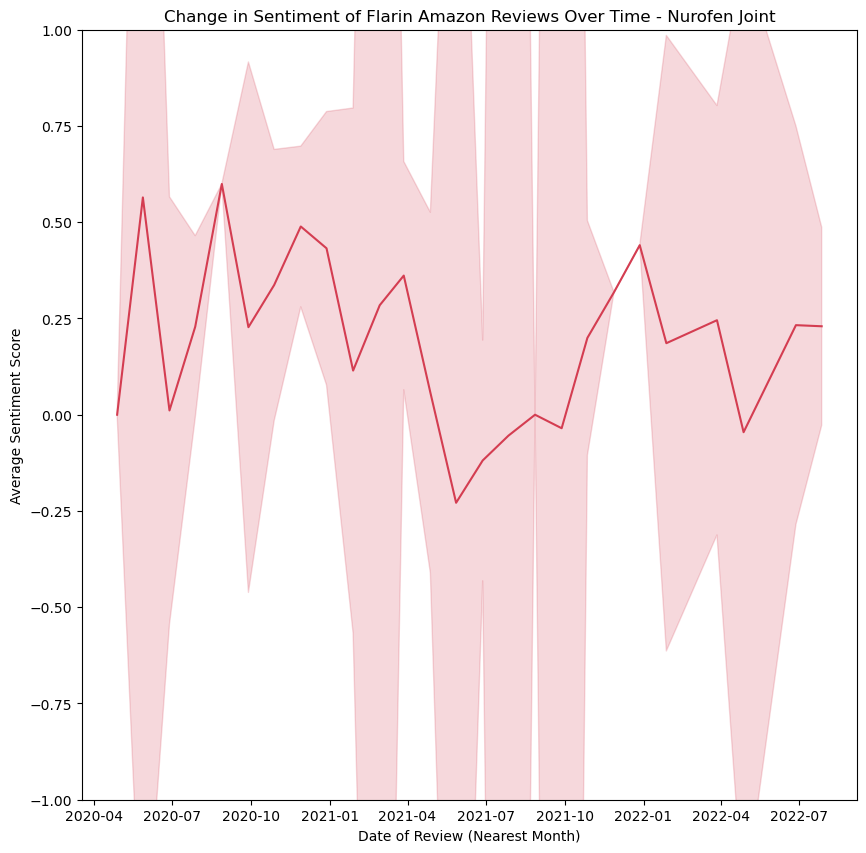

In [35]:
#Sentiment over time
today = datetime.now()
time_grouped_sentiments = {}

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

for i in range(len(tokenized_reviews)):
    age_months = diff_month(today,tokenized_reviews[i][1])
    if age_months in time_grouped_sentiments:
        time_grouped_sentiments[age_months].append(sentiments[i])
    else:
        time_grouped_sentiments[age_months] = [sentiments[i]]

months_old = []
avg_sentiments = []
errors_high = []
errors_low = []

for key in time_grouped_sentiments:
    values = time_grouped_sentiments[key]
    months_old.append(int(key))
    mean = statistics.mean(values)
    avg_sentiments.append(mean)
    standard_error = scipy.stats.sem(values)
    degrees_freedom = len(values)-1
    confidence_interval = scipy.stats.t.interval(0.95, degrees_freedom, mean, standard_error)
    if math.isnan(confidence_interval[0]):
        confidence_interval = (mean,mean)
    errors_low.append(confidence_interval[0])
    errors_high.append(confidence_interval[1])
    #print(f"Key: {key} Mean: {mean} Interval: {confidence_interval}")

order = np.argsort(months_old)
months_old_sorted = np.array(months_old)[order]
avg_sentiments_sorted = np.array(avg_sentiments)[order]
errors_high_sorted = np.array(errors_high)[order]
errors_low_sorted = np.array(errors_low)[order]

print(months_old_sorted)

time_labels = []

for i in months_old_sorted:
    date = today - relativedelta(months=i)
    time_labels.append(date)
print(avg_sentiments_sorted)
fig4 = plt.figure(figsize=(10,10))
plt.plot(time_labels,avg_sentiments_sorted,color='#d43d51')
ax = plt.gca()

ax.set_xlim(ax.get_xlim()[::1])
ax.set_ylim([-1,1])

plt.xlabel("Date of Review (Nearest Month)")
plt.ylabel("Average Sentiment Score")
plt.title("Change in Sentiment of Flarin Amazon Reviews Over Time - Nurofen Joint")

ax.fill_between(time_labels,errors_low_sorted,errors_high_sorted,color='#d43d51',alpha=0.2)
plt.show()
fig4.savefig("Nurofen-Joint/nurofen_joint_sentiment_over_time")

## Overall sentiment

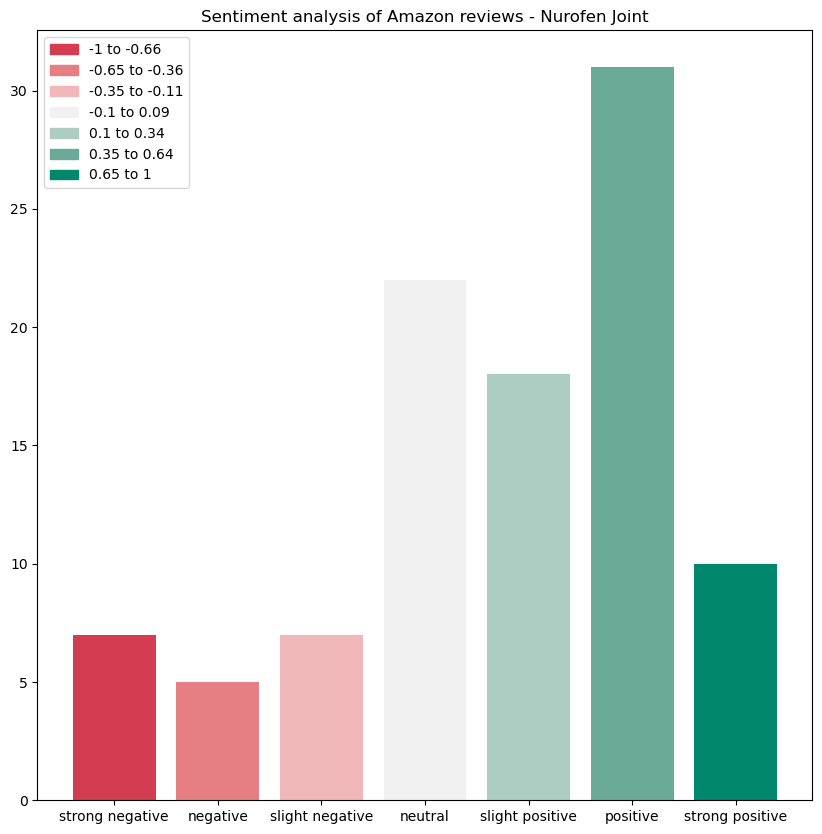

In [36]:
diverging_colors = ['#00876c',
'#6aaa96',
'#aecdc2',
'#f1f1f1',
'#f0b8b8',
'#e67f83',
'#d43d51']

reversed_colors = []
for color in diverging_colors:
    reversed_colors.insert(0,color)

fig2 = plt.figure(figsize = (10,10))
plt.bar(range(len(sentiment_counts)),sentiment_counts,tick_label = sentiment_labels,color = reversed_colors)

patches = []

for i in range(len(sentiment_labels)):
    patches.append(mpatches.Patch(color=reversed_colors[i], label=category_definitions[i]))

plt.legend(handles=patches)
plt.title("Sentiment analysis of Amazon reviews - Nurofen Joint")
plt.show()
fig2.savefig("Nurofen-Joint/nurofen_joint_sentiment_analysis")

## Spread of review sentiment over time (grouped every 3 months)

In [37]:
complicated_list = np.zeros([5,max(time_grouped_sentiments.keys())+1])

for key in time_grouped_sentiments:
    for sentiment in time_grouped_sentiments[key]:
        if sentiment < -0.6:
            complicated_list[0][key] += 1
        elif sentiment < -0.2:
            complicated_list[1][key] += 1
        elif sentiment < 0.2:
            complicated_list[2][key] += 1
        elif sentiment < 0.6:
            complicated_list[3][key] += 1
        else:
            complicated_list[4][key] += 1

In [38]:
grouped_data = []

for i in range(5):
    new_list = [x+y+z for x,y,z in zip(complicated_list[i][0::3], complicated_list[i][1::3], complicated_list[i][2::3])]
    grouped_data.append(new_list)

group_labels = []
for i in range(len(grouped_data[0])):
    group_labels.append(f"{i*3}-{(i+1)*3} months")

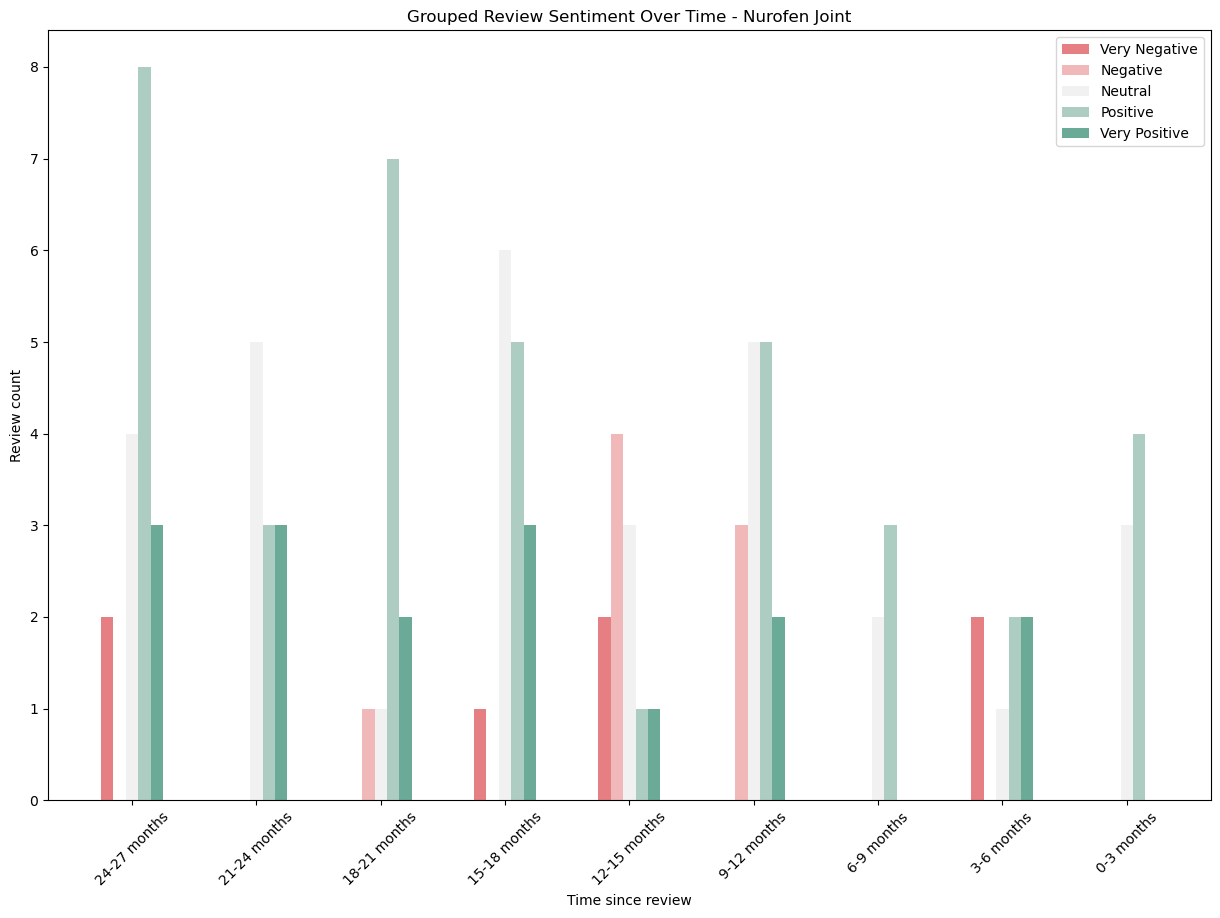

In [39]:
diverging_colors_narrow = ['#6aaa96',
'#aecdc2',
'#f1f1f1',
'#f0b8b8',
'#e67f83']

x = np.arange(len(grouped_data[0]))  # the label locations
width = 0.1  # the width of the bars

fig5 = plt.figure(figsize = (15,10))

cat_labels = ['Very Negative','Negative','Neutral','Positive','Very Positive']

for i in range(5):
    adjustment = i - (5-1)/2
    plt.bar(x + (adjustment*width), grouped_data[i][::-1], width,color=diverging_colors_narrow[::-1][i], label = cat_labels[i])

plt.xticks(x, group_labels[::-1],rotation = 45)
plt.xlabel('Time since review')
plt.ylabel('Review count')
plt.title('Grouped Review Sentiment Over Time - Nurofen Joint')
plt.legend()
plt.show()
fig5.savefig("Nurofen-Joint/nurofen_joint_sentiment_distribution")

# Wordcloud of commonly used words

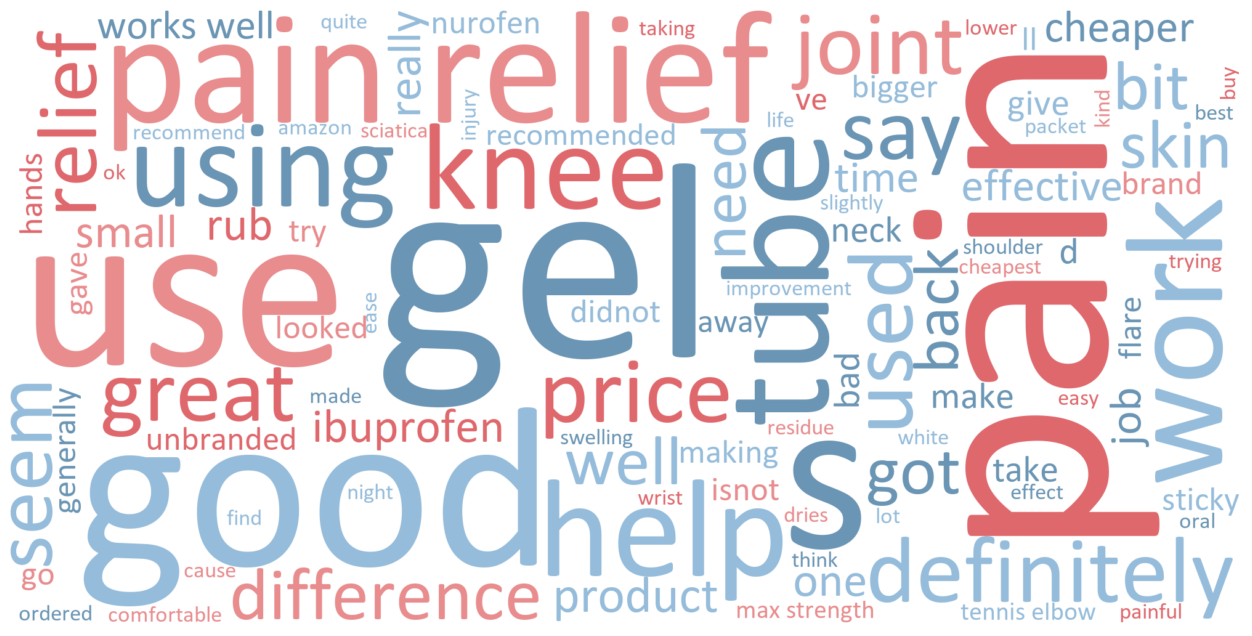

In [40]:
#Wordcloud of the amazon reviews

colorList = [(205, 33, 56),
             (206, 48, 72),
             (357, 65, 64),
             (359, 67, 73),

]

def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    seed = random.randint(0,len(colorList)-1)
    color = colorList[seed]
    h = color[0]
    s = color[1]
    l = color[2]
    return "hsl({}, {}%, {}%)".format(h, s, l)

fig3 = plt.figure(figsize=(16,8))
wc = wordcloud = WordCloud(width=2000, height=1000,font_path=r'C:\Windows\Fonts\Calibri.ttf',max_words = 100,background_color = "white",color_func=random_color_func).generate(" ".join(tokenized_words))
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show()
fig3.savefig("Nurofen-Joint/nurofen_joint_wordcloud")

## Longest Review
Just for fun :)

In [41]:
longest_review = ""
for review in review_list:
    if len(review) > len(longest_review):
        longest_review = review
print(longest_review)

("This is good for aching joints and  muscles for someone who doesn't really like taking pain killers. It's easy to use, although I noticed that after just one use of using a pea-sized amount, the tube looked half empty. A bit like opening a bag of crisps and realising you've paid for a lot of air!However, the main thing is this gel works, rubs in easily and provides relief from pain.", datetime.datetime(2020, 9, 28, 0, 0))


# Reviews mentioning the stomach over time

In [42]:
stomachs = []

for review in tokenized_reviews:
    if 'stomach' in review[0]:
        stomachs.append(review[1])

months_ago_stomach = []
        
for date in stomachs:
    months_old = diff_month(today,date)
    months_ago_stomach.append(months_old)
    
stomach_results = np.zeros(max(months_ago_stomach)+1)

for result in months_ago_stomach:
    stomach_results[result] += 1

ValueError: max() arg is an empty sequence

In [ ]:
stomach_time_labels = []

for i in range(len(stomach_results)):
    date = today - relativedelta(months=i)
    stomach_time_labels.append(date)

In [ ]:
fig6 = plt.figure(figsize = (15,10))
plt.plot(stomach_time_labels,stomach_results)
plt.xlabel("Time")
plt.ylabel("Reviews mentioning 'Stomach'")
plt.show()
fig6.savefig("Nurofen-Joint/nurofen_joint_stomach_mentions")